In [89]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src import glide_path_portfolio
importlib.reload(glide_path_portfolio)
from src import withdrawal_solver
importlib.reload(withdrawal_solver)

<module 'src.withdrawal_solver' from '/Users/K/works/git/decumulation4/src/withdrawal_solver.py'>

In [90]:
# 各資産の年率期待リターン
mu_assets = {
    "asset0": 1.43*1e-02,
    "asset1": 5.19*1e-02,
    "asset2": 3.46*1e-02,
    "asset3": 0.86*1e-02,
    "asset4": 5.95*1e-02,
    "asset5": 2.67*1e-02,
    "asset6": 5.84*1e-02,
    "asset7": 7.28*1e-02,
    "asset8": 0,
}
# 各資産の年率期待リスク
sig_assets = {
    "asset0": np.sqrt(2.36*1e-02),
    "asset1": np.sqrt(14.60*1e-02),
    "asset2": np.sqrt(7.48*1e-02),
    "asset3": np.sqrt(4.75*1e-02),
    "asset4": np.sqrt(17.13*1e-02),
    "asset5": np.sqrt(14.45*1e-02),
    "asset6": np.sqrt(14.46*1e-02),
    "asset7": np.sqrt(18.99*1e-02),
    "asset8": 0,
}

Sig = np.array([
    [0.056*1e-02, -0.034*1e-02, 0.012*1e-02, 0.056*1e-02, 0.002*1e-02, 0.053*1e-02, 0.065*1e-02, 0.073*1e-02, 0.000*1e-02],
    [-0.034*1e-02, 2.130*1e-02, 0.520*1e-02, -0.100*1e-02, 1.939*1e-02, 1.332*1e-02, 0.970*1e-02, 1.584*1e-02, 0.000*1e-02],
    [0.012*1e-02, 0.520*1e-02, 0.560*1e-02, -0.014*1e-02, 0.786*1e-02, 0.223*1e-02, 0.207*1e-02, 0.674*1e-02, 0.000*1e-02],
    [0.056*1e-02, -0.100*1e-02, -0.014*1e-02, 0.226*1e-02, -0.132*1e-02, 0.166*1e-02, 0.012*1e-02, 0.086*1e-02, 0.000*1e-02],
    [0.002*1e-02, 1.939*1e-02, 0.786*1e-02, -0.132*1e-02, 2.935*1e-02, 1.919*1e-02, 1.104*1e-02, 2.576*1e-02, 0.000*1e-02],
    [0.053*1e-02, 1.332*1e-02, 0.223*1e-02, 0.166*1e-02, 1.919*1e-02, 2.087*1e-02, 0.909*1e-02, 2.002*1e-02, 0.000*1e-02],
    [0.065*1e-02, 0.970*1e-02, 0.207*1e-02, 0.012*1e-02, 1.104*1e-02, 0.909*1e-02, 2.090*1e-02, 1.389*1e-02, 0.000*1e-02],
    [0.073*1e-02, 1.584*1e-02, 0.674*1e-02, 0.086*1e-02, 2.576*1e-02, 2.002*1e-02, 1.389*1e-02, 3.606*1e-02, 0.000*1e-02],
    [0.000*1e-02, 0.000*1e-02, 0.000*1e-02, 0.000*1e-02, 0.000*1e-02, 0.000*1e-02, 0.000*1e-02, 0.000*1e-02, 0.000*1e-02],
])

In [91]:
# 各リスク許容度RTごとのポートフォリオのボラティリティと期待リターンとアロケーション
weights = pd.DataFrame()
weights["RT"] = np.arange(0, 10, 1)
weights["Vol"] = [0, 0.0243, 0.0326, 0.0431, 0.0586, 0.0735, 0.0891, 0.1076, 0.1199, 0.1291]
weights["E[r]"] = [0.0001, 0.0165, 0.0214, 0.0274, 0.0335, 0.039, 0.0439, 0.0491, 0.053, 0.0556]
weights["asset0"] = [0, 0.2, 0.26, 0.3, 0.23, 0.18, 0.13, 0.07, 0.03, 0]
weights["asset1"] = [0, 0.06, 0.09, 0.1, 0.13, 0.16, 0.18, 0.21, 0.23, 0.24]
weights["asset2"] = [0, 0.14, 0.18, 0.23, 0.22, 0.2, 0.19, 0.16, 0.15, 0.11]
weights["asset3"] = [0, 0.16, 0.2, 0.24, 0.19, 0.14, 0.09, 0.04, 0, 0]
weights["asset4"] = [0, 0.02, 0.02, 0.03, 0.08, 0.12, 0.17, 0.22, 0.25, 0.29]
weights["asset5"] = [0, 0, 0, 0, 0, 0, 0.01, 0.04, 0.05, 0.05]
weights["asset6"] = [0, 0.04, 0.06, 0.08, 0.1, 0.12, 0.12, 0.12, 0.13, 0.13]
weights["asset7"] = [0, 0, 0, 0.02, 0.05, 0.08, 0.11, 0.14, 0.16, 0.18]
weights["asset8"] = [1, 0.38, 0.19, 0, 0, 0, 0, 0, 0, 0]

In [92]:
# ---- Simulation helpers ----
def annual_to_period_params(mu_a: float, sig_a: float, periods_per_year: int, model: str = "gaussian"):
    P = periods_per_year
    if model == "gaussian":
        mu_p = mu_a / P
        sig_p = sig_a / np.sqrt(P)
        return mu_p, sig_p
    elif model == "gbm":
        mu_log_p = np.log(1.0 + mu_a) / P
        sig_log_p = sig_a / np.sqrt(P)
        return mu_log_p, sig_log_p
    else:
        raise ValueError("model must be 'gaussian' or 'gbm'")

def simulate_returns(mu_dict, sig_dict, n_periods=120, freq="M", model="gaussian", corr=None, seed=42):
    rng = np.random.default_rng(seed)
    assets = list(mu_dict.keys())
    n = len(assets)
    if freq == "M":
        P = 12
    elif freq == "W":
        P = 52
    elif freq == "D":
        P = 252
    else:
        raise ValueError("freq must be one of 'M', 'W', 'D'")

    if corr is None:
        R = np.eye(n)
    else:
        R = corr.reindex(index=assets, columns=assets).to_numpy()

    if model == "gaussian":
        mu_p = np.array([annual_to_period_params(mu_dict[a], sig_dict[a], P, "gaussian")[0] for a in assets])
        sig_p = np.array([annual_to_period_params(mu_dict[a], sig_dict[a], P, "gaussian")[1] for a in assets])
        D = np.diag(sig_p)
        cov = D @ R @ D
        shocks = rng.multivariate_normal(mean=np.zeros(n), cov=cov, size=n_periods)
        rets = shocks + mu_p
    else:
        mu_log_p = np.array([annual_to_period_params(mu_dict[a], sig_dict[a], P, "gbm")[0] for a in assets])
        sig_log_p = np.array([annual_to_period_params(mu_dict[a], sig_dict[a], P, "gbm")[1] for a in assets])
        D = np.diag(sig_log_p)
        cov_log = D @ R @ D
        eps = rng.multivariate_normal(mean=np.zeros(n), cov=cov_log, size=n_periods)
        rets = np.exp(mu_log_p + eps) - 1.0

    idx = pd.date_range(start="2005-01-31", periods=n_periods, freq=freq)
    df = pd.DataFrame(rets, index=idx, columns=assets)
    return df

# ---- Run a default simulation (monthly, 10 years = 120 periods) ----
df_returns = simulate_returns(mu_assets, sig_assets, n_periods=120, freq="M", model="gaussian", corr=None, seed=123)

In [93]:
# ブートストラップ法でリサンプリング
def bootstrap(rets, n_steps):
    return rets.sample(n_steps, replace=True).values

In [103]:
INIT_VAL = 100
WITHDRAWAL_RATE = 0.03 / 12 # per month
RT = 3
N_STEPS = 12 * 35 # month
N_PATHS = 10
AGE = np.arange(65, 100+1/12, 1/12)

rets = bootstrap(df_returns, n_steps=N_STEPS)

In [104]:
model = glide_path_portfolio.GlidePathPortfolio(weights)

In [105]:
lst_rets = np.array([
    bootstrap(df_returns, n_steps=N_STEPS) for _ in range(N_PATHS)
])

In [106]:
rate_ann, monthly_amt2 = withdrawal_solver.solve_annual_rate_of_initial_for_scenario_zero_glide(
    GlidePathPortfolioCls=glide_path_portfolio.GlidePathPortfolio,
    weights_df=weights,
    init_rt=RT,
    init_val=INIT_VAL,
    contribution=0,
    T=N_STEPS,
    n_assets=9,
    const=True,
    pre_scenario=None,
    low_rate_ann=0.0,
    high_rate_ann=0.20,  # 必要に応じて自動拡張（最大1000%/年まで）
)
print(f"年率（初期資産比）: {rate_ann:.2%}, 月額換算: {monthly_amt2}")


年率（初期資産比）: 3.41%, 月額換算: 0.2842027360320642


In [112]:
WITHDRAWAL_RATE = monthly_amt2/INIT_VAL
WITHDRAWAL_RATE

0.002842027360320642

In [113]:
def get_scenario(model, paths, init_rt, init_val, contribution, withdrawal, const, n_steps, n_paths):
    lst_S = []
    for _ in range(n_paths):
        rets = paths[_, :]
        S, _, _ = model.run(
            rets=rets,
            init_rt=init_rt,
            init_val=init_val,
            contribution=contribution,
            withdrawal=withdrawal,
            const=True
        )
        lst_S.append(S)
    return np.array(lst_S)

In [114]:
S, _, _ = model.run(
    rets=rets,
    init_rt=RT,
    init_val=INIT_VAL,
    contribution=0,
    withdrawal=WITHDRAWAL_RATE*INIT_VAL,
    const=True
)

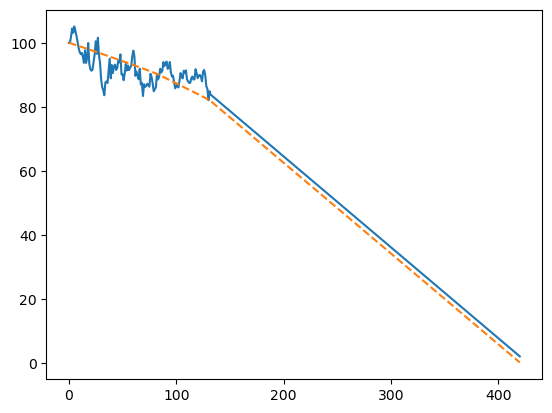

In [115]:
plt.plot(S)
plt.plot(model.scenario, ls="--")
plt.show()

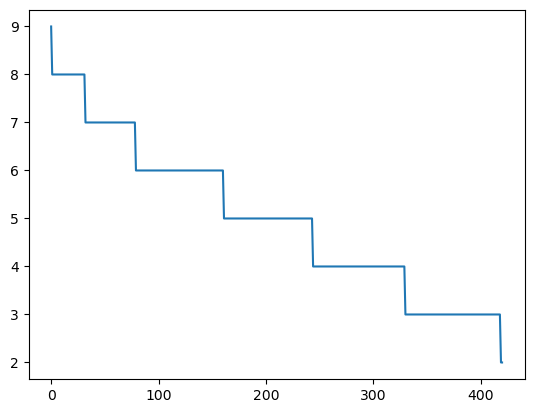

In [79]:
plt.plot(model.record_rt)
plt.show()